# Notebook Details
This notebook can be run to get the final forecast errors of all models used in study. Their architechtures were based on those found in the paper *Statistical and Machine Learning forecasting methods: Concerns and ways forward* by *Spyros Makridakis, Evangelos Spiliotis, and Vassilios Assimakopoulos*. However, some hyperparameters and aspects of their architechture were further optimised using the grid-search method. Some extra models were also used in this study that did not appear in the paper by *Makridakis et. al.*
<br><br>
**Author**: Ruan Pretorius<br>
**Date**: September 2020

In [1]:
from datetime import datetime
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Note
The data was downloaded and processed for use in this notebook by the notebook called `get_q500us_from_yfinance_and_select_valid_series.ipynb` located in at `../data/Q500US Data/`.

# Table of Contents

* [Load Previously Saved Raw Data](#1)
* [Plot Raw Data](#2)
* [Preprocess Data](#3)
* [Prediction on Single Series](#4)
    * [Define Stats Models](#4.1)
    * [Fit Stats Models and Get Forecasts](#4.2)
    * [Define, Fit, and Get Forecasts from ML Models](#4.3)
    * [Define and Get Forecasts from Combo Models](#4.4)
    * [Combine All Model Predictions](#4.5)
    * [Plot Forecasts for Single Series](#4.6)
    * [Define Accuracy Metrics](#4.7)
    * [Forecast Errors of All Models](#4.8)
        * [sMAPE Summary](#4.8.1)
        * [MASE Summary](#4.8.2)
        * [OWA Summary](#4.8.3)
* [Test for Multiple Series](#5)
    * [Select Series (Tickers) for Test](#5.1)
    * [Fit All ML and Stats Models, Produce Forecasts, and Calculate Errors](#5.2)
    * [Forecast Errors of All Models](#5.3)
        * [sMAPE Summary (Averaged Across All Series/Tickers)](#5.3.1)
        * [MASE Summary (Averaged Across All Series/Tickers)](#5.3.2)
        * [OWA Summary (Averaged Across All Series/Tickers)](#5.3.3)
    * [Error Plot for All Models and Specific Forecast Horizon](#5.4)
        * [sMAPE Plot](#5.4.1)
        * [MASE Plot](#5.4.2)
        * [OWA Plot](#5.4.3)

# Load Previously Saved Raw Data <a class="anchor" id="1"></a>

In [3]:
data_dir = '../data/Q500US Data/useable_historical_data'

all_data_files = glob.glob(data_dir + "/*.csv")

ticker_dfs = []
file_tickers_list = []

for filename in all_data_files:
    ticker = filename.split('data\\')[1].split('_1mo')[0]    
    file_tickers_list.append(ticker)
    df = pd.read_csv(filename, header=0) #    df = pd.read_csv(filename, header=0) 
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    #ticker_dfs.append(df)
    ticker_dfs.append(df['Adj Close'])

#pd.concat([df1, df2], axis=1, keys=['ABC', 'XYZ'])
data = pd.concat(ticker_dfs, axis=1, keys=file_tickers_list)
data.head()

,AAL,AAPL,AAP,AA,ABC,ABMD,ABT,ACN,ADBE,ADI,...,XEC,XEL,XLNX,XOM,X,YNDX,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,8.522383,30.064436,52.956436,22.827152,23.381828,9.03,17.326826,29.592354,27.700001,21.548641,...,60.753342,15.504700,19.241819,41.928932,38.941261,NaN,24.778725,43.766262,28.620001,16.518063
2010-09-01,8.720360,35.091660,57.049446,27.118992,26.351110,10.61,18.345226,34.354626,26.150000,24.437187,...,61.528133,15.963382,21.356985,44.143589,40.219963,NaN,27.369501,48.553921,33.639999,19.163160
2010-10-01,11.114922,37.222515,63.239353,29.425564,28.216146,10.31,18.022148,36.149551,28.150000,26.220516,...,71.355171,16.765200,21.485254,47.501328,39.192459,NaN,29.449257,44.016777,35.779999,18.615898
2010-11-01,10.520993,38.480263,64.222305,29.403162,26.514404,11.48,16.617804,35.373795,27.799999,27.692362,...,74.878738,16.512245,21.749809,49.694580,44.596104,NaN,29.914371,45.705444,36.439999,17.449602


In [4]:
len(file_tickers_list)

403

# Plot Raw Data <a class="anchor" id="2"></a>

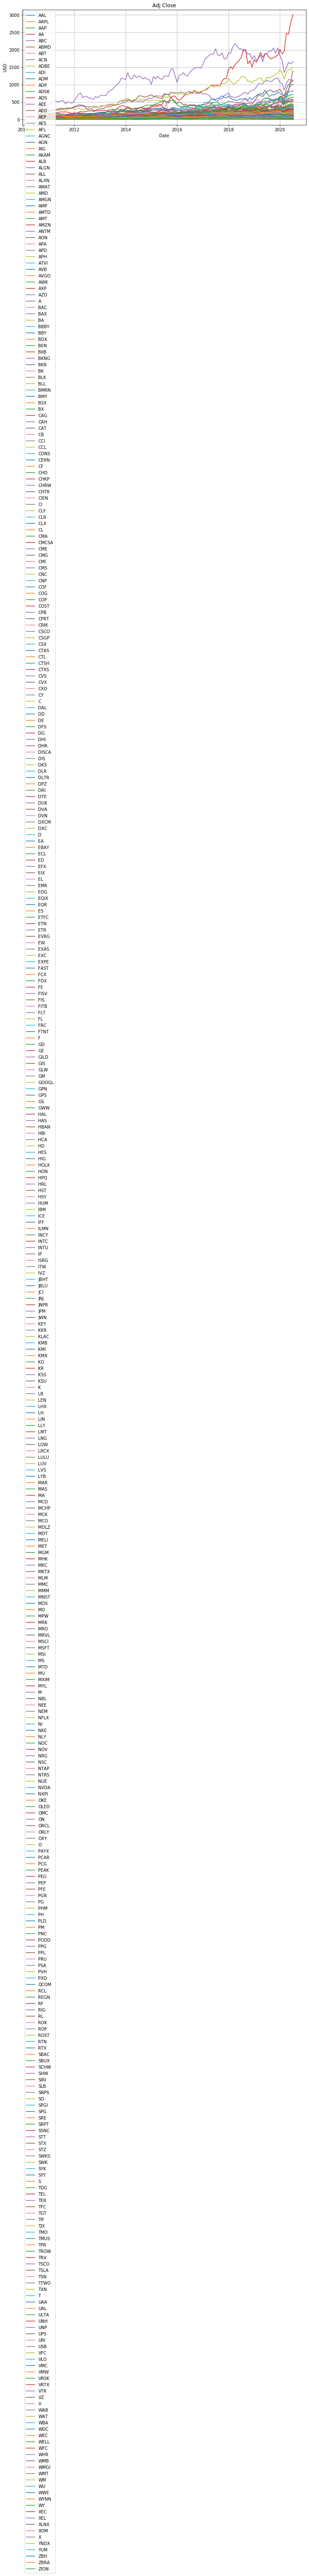

In [5]:
attribute = 'Adj Close'
plt.figure(figsize=(12,5))
for ticker in file_tickers_list:
    #plt.plot(data[ticker][attribute],label=ticker)
    plt.plot(data[ticker],label=ticker)
    
plt.legend()
plt.title(attribute)
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()

# Preprocess Data <a class="anchor" id="3"></a>

### Train Test Split (18 Months)

In [6]:
jan_2020 = -8 # the row id of january 2020 - we want to exclude this from the data
data_test = data.iloc[jan_2020-18:jan_2020]
data_train = data.iloc[:jan_2020-18]

print('test data size:',data_test.shape[0])
print('train data size:',data_train.shape[0])

test data size: 18
train data size: 96


# Prediction on Single Series <a class="anchor" id="4"></a>

In [7]:
#list(data_train.columns)

In [8]:
test_icker_list = ['AAPL','AMD','AMZN','GOOGL','EBAY','XLNX']

#ticker_sym = 'AAPL'
ticker_sym = test_icker_list[3]
ticker_sym

'GOOGL'

In [9]:
nb_preds = 18

### Differnet Models:

### Define Stats Models <a class="anchor" id="4.1"></a>

In [10]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression

In [11]:
ticker_mean = data_train[ticker_sym].mean()
ticker_std = data_train[ticker_sym].std()
print('{:s} log ret mean:'.format(ticker_sym),ticker_mean)
print('{:s} log ret std:'.format(ticker_sym),ticker_std)

GOOGL log ret mean: 584.6396966231497
GOOGL log ret std: 260.600350328807


In [12]:
# random prediction with same mean and std as time series
def rand_train_and_pred(data_train, ticker_sym, rand_seed=111, nb_pred=18):
    ticker_mean = data_train[ticker_sym].mean()
    ticker_std = data_train[ticker_sym].std()
    np.random.seed(rand_seed)
    pred_rand = np.random.normal(loc=ticker_mean, scale=ticker_std, size=nb_pred)
    return pred_rand

In [13]:
# naive prediction
def naive_train_and_pred(data_train, ticker_sym, nb_pred=18):
    pred_naive = np.ones(nb_pred) * data_train.iloc[-1][ticker_sym]
    return pred_naive

In [14]:
# SES prediction
def SES_train_and_pred(data_train, ticker_sym, alpha, nb_pred=18, repl_nan=0.0):
    SES_fit = SimpleExpSmoothing(np.nan_to_num(data_train[ticker_sym].values, copy=True, nan=repl_nan)).fit(smoothing_level=alpha) # smoothing_level
    pred_SES = SES_fit.forecast(nb_pred)
    return pred_SES

In [15]:
# HLT prediction
def HLT_train_and_pred(data_train, ticker_sym, alpha, beta, nb_pred=18):
    HLT_fit = Holt(np.nan_to_num(data_train[ticker_sym].values)).fit(smoothing_level=alpha, smoothing_slope=beta) #smoothing_level=alpha, smoothing_slope=beta
    pred_HLT = HLT_fit.forecast(nb_pred)
    return pred_HLT

In [16]:
# Damped ES prediction
def damped_train_and_pred(data_train, ticker_sym, alpha, beta, phi, nb_pred=18):
    damped_fit = Holt(np.nan_to_num(data_train[ticker_sym].values), damped=True).fit(smoothing_level=alpha, smoothing_slope=beta, damping_slope=phi) #smoothing_level=alpha, smoothing_slope=beta, damping_slope=phi
    pred_damped = damped_fit.forecast(nb_pred)
    return pred_damped

In [17]:
# Comb prediction
def comb_train_and_pred(pred_SES, pred_HLT, pred_damped):
    comb = [pred_SES, pred_HLT, pred_damped]
    pred_comb = np.mean(comb, axis=0)
    return pred_comb

In [18]:
# Comb prediction
def general_combo_train_and_pred(pred_list):
    pred_comb = np.mean(pred_list, axis=0)
    return pred_comb

In [19]:
# ARIMA prediction
def ARIMA_train_and_pred(data_train, ticker_sym, order=(5,1,1), nb_pred=18):
    arima_fit = ARIMA(np.nan_to_num(data_train[ticker_sym].values), order=order).fit()
    pred_arima = arima_fit.forecast(nb_pred)
    return pred_arima

In [20]:
# ARMA prediction
def ARMA_train_and_pred(data_train, ticker_sym, order=(5,0,1), nb_pred=18):
    arma_fit = ARIMA(np.nan_to_num(data_train[ticker_sym].values), order=order).fit()
    pred_arma = arma_fit.forecast(nb_pred)
    return pred_arma

In [21]:
# AR prediction
def AR_train_and_pred(data_train, ticker_sym, order=(5,0,0), nb_pred=18):
    ar_fit = ARIMA(np.nan_to_num(data_train[ticker_sym].values), order=order).fit()
    pred_ar = ar_fit.forecast(nb_pred)
    return pred_ar

In [22]:
# Theta prediction
def theta_train_and_pred(data_train, data_test, ticker_sym, SES_alpha, repl_nan=0.0, nb_pred=18):
    
    # SES prediction
    SES_fit = SimpleExpSmoothing(np.nan_to_num(data_train[ticker_sym].values, copy=True, nan=repl_nan)).fit(smoothing_level=SES_alpha) # smoothing_level
    pred_SES = SES_fit.forecast(nb_pred)
    
    # Linear regression prediction
    X_train = np.array((data_train[ticker_sym].index -  data_train[ticker_sym].index[0]).days).reshape(-1, 1)
    y_train = np.nan_to_num(data_train[ticker_sym].values)

    lin_reg_model = LinearRegression(n_jobs=-1).fit(X_train, y_train)

    X_test = np.array((data_test[ticker_sym].index -  data_train[ticker_sym].index[0]).days)[0:nb_pred].reshape(-1, 1)
    pred_lin_reg = lin_reg_model.predict(X_test)
    
    # get average of SES and linear regression predictions
    comb = [pred_SES, pred_lin_reg]
    pred_theta = np.mean(comb, axis=0)
    return pred_theta

### Fit Stats Models with Optimal Parameters and Get Forecasts <a class="anchor" id="4.2"></a>

In [25]:
### random prediction
pred_rand_ns = rand_train_and_pred(data_train, ticker_sym, rand_seed=111, nb_pred=18)

### naive prediction
pred_naive_ns = naive_train_and_pred(data_train, ticker_sym, nb_pred=18)

### simple exponential smoothing (SES)
pred_SES_ns = SES_train_and_pred(data_train, ticker_sym, alpha=0.2, nb_pred=18, repl_nan=0.0)

### Holt's linear trend (HLT)
pred_HLT_ns = HLT_train_and_pred(data_train, ticker_sym, alpha=0.2, beta=0.2, nb_pred=18)

### Damped trend
pred_damped_ns = damped_train_and_pred(data_train, ticker_sym, alpha=0.2, beta=0.8, phi=0.8, nb_pred=18)

### AR
pred_ar = AR_train_and_pred(data_train, ticker_sym, order=(1,0,0), nb_pred=18)

### ARMA
pred_arma = ARMA_train_and_pred(data_train, ticker_sym, order=(5,0,1), nb_pred=18)

### ARIMA
pred_arima = ARIMA_train_and_pred(data_train, ticker_sym, order=(1,1,1), nb_pred=18)

### combination of HLT, SES, and damped (comb)
pred_comb_ns = comb_train_and_pred(pred_SES_ns, pred_HLT_ns, pred_damped_ns)

### Theta
pred_theta = theta_train_and_pred(data_train, data_test, ticker_sym, SES_alpha=0.2, repl_nan=0.0, nb_pred=18)

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### Define, Fit, and Get Forecasts from ML Models with Optimal Parameters <a class="anchor" id="4.3"></a>

In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam
#from tensorflow.keras.metrics import categorical_crossentropy

print('Tensorfllow version = ',tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('number of availible GPUs = ', len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

Tensorfllow version =  1.14.0
number of availible GPUs =  0


#### Prepare data for ML models

In [24]:
def prepare_data_for_ML_models(data_train, ticker_sym, inp_param=5):
    ### convert close price training data of specific ticker into array
    data_train_arr = np.nan_to_num(data_train[ticker_sym].values.reshape(-1,1), copy=True, nan=0.0)
    
    ### scale training data
    sc = MinMaxScaler(feature_range = (0, 1))
    data_train_scaled = sc.fit_transform(data_train_arr)
    
    ### get training X and y in correct format for training models

    X_train = []
    y_train = []
    N = inp_param # number of inputs (lagged values)

    for i in range(N, data_train_scaled.shape[0]):
        X_train.append(data_train_scaled[i-N:i, 0])
        y_train.append(data_train_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    return X_train, y_train, sc

In [25]:
## for 10 lagged values
X_train_10, y_train_10, sc_10 = prepare_data_for_ML_models(data_train, ticker_sym, inp_param=10)

## for 5 lagged values
X_train_5, y_train_5, sc_5 = prepare_data_for_ML_models(data_train, ticker_sym, inp_param=5)

#### LSTM

In [26]:
def LSTM_train_and_pred(X_train, y_train, sc, nb_preds=18, hidden_units=11, inp_param=5, learning_rate=0.001, loss='mean_squared_error', epochs=500, batch_size=10, verbose=1):
    
    ### reshape data into 3D array
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    ### build LSTM model
    print('building LSTM model...')
    lstm = Sequential([
        LSTM(units=hidden_units, return_sequences=False, input_shape=(X_train.shape[1], 1)),
        Dense(units=1, activation='linear')
    ])

    lstm.compile(optimizer=RMSprop(learning_rate=learning_rate), loss=loss)
    #print(lstm.summary())
    
    ### fit to training data
    print('training LSTM model...')
    lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=False, verbose=verbose)
    
    ## make predictor - loop 18 times using last pred as latest input
    print('making LSTM predictions...')
    pred_lstm = []

    # initial inputs required for first predicion
    #inp = data_train[ticker_sym][-N:].values.reshape(-1,1)
    inp = sc.inverse_transform(np.vstack((X_train[-1:][0], y_train[-1]))[-inp_param:].reshape(-1,1))
    inp_scaled = sc.transform(inp)
    inp_scaled = np.reshape(inp_scaled, (inp_scaled.shape[1], inp_scaled.shape[0], 1)) # 3D format
    #inp.shape

    # make predictions
    for i in range(nb_preds):
        prediction = lstm.predict(inp_scaled)
        prediction = sc.inverse_transform(prediction) 
        prediction = float(prediction[0])
        pred_lstm.append(prediction)
        #prediction

        inp = np.roll(inp, -1)
        inp[-1] = prediction
        inp_scaled = sc.transform(inp)
        inp_scaled = np.reshape(inp_scaled, (inp_scaled.shape[1], inp_scaled.shape[0], 1))

    pred_lstm = np.array(pred_lstm)
    print('done.')
    return pred_lstm

In [30]:
pred_lstm = LSTM_train_and_pred(X_train_10, y_train_10, sc_10, nb_preds=18, hidden_units=21, inp_param=10, learning_rate=0.001, loss='mean_squared_error', epochs=500, batch_size=10, verbose=1)

building LSTM model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
training LSTM model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/500
86/86 [==============================] - 0s 5ms/sample - loss: 0.0751
Epoch 2/500
86/86 [==============================] - 0s 579us/sample - loss: 0.0094
Epoch 3/500
86/86 [==============================] - 0s 578us/sample - loss: 0.0050
Epoch 4/500
86/86 [==============================] - 0s 559us/sample - loss: 0.0054
Epoch 5/500
86/86 [==============================] - 0s 568us/sample - loss: 0.0049
Epoch 6/500
86/86 [==============================] - 0s 585us/sample - loss: 0.0044
Epoch 7/500
86/86 [==============================] - 0s 557us/sample - loss: 0.0038
Epoch 8/500
86/86 [==============================] - 0s 546us/sample - loss: 0.0034
Epoch 9/500
86/86 [==============================] - 0s 533us/sample - l

86/86 [==============================] - 0s 502us/sample - loss: 0.0015
Epoch 184/500
86/86 [==============================] - 0s 495us/sample - loss: 0.0015
Epoch 185/500
86/86 [==============================] - 0s 498us/sample - loss: 0.0015
Epoch 186/500
86/86 [==============================] - 0s 487us/sample - loss: 0.0015
Epoch 187/500
86/86 [==============================] - 0s 488us/sample - loss: 0.0015
Epoch 188/500
86/86 [==============================] - 0s 487us/sample - loss: 0.0015
Epoch 189/500
86/86 [==============================] - 0s 487us/sample - loss: 0.0015
Epoch 190/500
86/86 [==============================] - 0s 489us/sample - loss: 0.0014
Epoch 191/500
86/86 [==============================] - 0s 491us/sample - loss: 0.0014
Epoch 192/500
86/86 [==============================] - 0s 487us/sample - loss: 0.0014
Epoch 193/500
86/86 [==============================] - 0s 475us/sample - loss: 0.0014
Epoch 194/500
86/86 [==============================] - 0s 487us/samp

86/86 [==============================] - 0s 505us/sample - loss: 0.0011
Epoch 374/500
86/86 [==============================] - 0s 487us/sample - loss: 0.0011
Epoch 375/500
86/86 [==============================] - 0s 503us/sample - loss: 0.0011
Epoch 376/500
86/86 [==============================] - 0s 510us/sample - loss: 0.0011
Epoch 377/500
86/86 [==============================] - 0s 500us/sample - loss: 0.0011
Epoch 378/500
86/86 [==============================] - 0s 499us/sample - loss: 0.0011
Epoch 379/500
86/86 [==============================] - 0s 487us/sample - loss: 0.0011
Epoch 380/500
86/86 [==============================] - 0s 510us/sample - loss: 0.0011
Epoch 381/500
86/86 [==============================] - 0s 522us/sample - loss: 0.0011
Epoch 382/500
86/86 [==============================] - 0s 487us/sample - loss: 0.0011
Epoch 383/500
86/86 [==============================] - 0s 504us/sample - loss: 0.0011
Epoch 384/500
86/86 [==============================] - 0s 499us/samp

In [31]:
pred_lstm

array([1127.19909668, 1121.69641113, 1121.46716309, 1125.1574707 ,
       1129.83166504, 1133.8269043 , 1137.17431641, 1140.26147461,
       1143.20751953, 1145.85742188, 1148.20581055, 1150.34985352,
       1152.35925293, 1154.24768066, 1156.00488281, 1157.62597656,
       1159.11743164, 1160.49084473])

#### MLP

In [27]:
def MLP_train_and_pred(X_train, y_train, sc, nb_preds=18, hidden_units=11, inp_param=5, learning_rate=0.001, loss='mean_squared_error', epochs=500, batch_size=10, verbose=1):
    ### build LSTM model
    print('building MLP model...')
    mlp = Sequential([
        Dense(units=hidden_units, activation='sigmoid', input_shape=(X_train.shape[1], )),
        Dense(units=1, activation='linear')
    ])

    mlp.compile(optimizer=RMSprop(learning_rate=learning_rate), loss=loss)
    
    ### fit to training data
    print('training MLP model...')
    mlp.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=False, verbose=verbose)
    
    ## make predictor - loop 18 times using last pred as latest input
    print('making MLP predictions...')
    pred_mlp = []

    # initial inputs required for first predicion
    #inp = data_train[ticker_sym][-N:].values.reshape(-1,1)
    inp = sc.inverse_transform(np.hstack((X_train[-1:][0], y_train[-1]))[-inp_param:].reshape(-1,1))
    inp_scaled = sc.transform(inp)
    #inp_scaled = np.reshape(inp_scaled, (inp_scaled.shape[1], inp_scaled.shape[0])) # 3D format
    inp_scaled = inp_scaled.reshape(1,-1) # 2D format
    #inp.shape

    # make predictions
    for i in range(nb_preds):
        prediction = mlp.predict(inp_scaled)
        prediction = sc.inverse_transform(prediction) 
        prediction = float(prediction[0])
        pred_mlp.append(prediction)
        #prediction

        inp = np.roll(inp, -1)
        inp[-1] = prediction
        inp_scaled = sc.transform(inp)
        #inp_scaled = np.reshape(inp_scaled, (inp_scaled.shape[1], inp_scaled.shape[0], 1)) # 3D format
        inp_scaled = inp_scaled.reshape(1,-1) # 3D format

    pred_mlp = np.array(pred_mlp)
    print('done.')
    return pred_mlp

In [33]:
pred_mlp = MLP_train_and_pred(X_train_10, y_train_10, sc_10, nb_preds=18, hidden_units=21, inp_param=10, learning_rate=0.001, loss='mean_squared_error', epochs=500, batch_size=10, verbose=1)

building MLP model...
training MLP model...
Epoch 1/500
86/86 [==============================] - 0s 2ms/sample - loss: 0.7394
Epoch 2/500
86/86 [==============================] - 0s 81us/sample - loss: 0.4186
Epoch 3/500
86/86 [==============================] - 0s 81us/sample - loss: 0.2510
Epoch 4/500
86/86 [==============================] - 0s 90us/sample - loss: 0.1403
Epoch 5/500
86/86 [==============================] - 0s 92us/sample - loss: 0.0689
Epoch 6/500
86/86 [==============================] - 0s 81us/sample - loss: 0.0278
Epoch 7/500
86/86 [==============================] - 0s 81us/sample - loss: 0.0088
Epoch 8/500
86/86 [==============================] - 0s 91us/sample - loss: 0.0029
Epoch 9/500
86/86 [==============================] - 0s 81us/sample - loss: 0.0023
Epoch 10/500
86/86 [==============================] - 0s 71us/sample - loss: 0.0024
Epoch 11/500
86/86 [==============================] - 0s 82us/sample - loss: 0.0025
Epoch 12/500
86/86 [======================

86/86 [==============================] - 0s 64us/sample - loss: 0.0022
Epoch 99/500
86/86 [==============================] - 0s 69us/sample - loss: 0.0022
Epoch 100/500
86/86 [==============================] - 0s 65us/sample - loss: 0.0022
Epoch 101/500
86/86 [==============================] - 0s 69us/sample - loss: 0.0022
Epoch 102/500
86/86 [==============================] - 0s 70us/sample - loss: 0.0022
Epoch 103/500
86/86 [==============================] - 0s 70us/sample - loss: 0.0022
Epoch 104/500
86/86 [==============================] - 0s 69us/sample - loss: 0.0021
Epoch 105/500
86/86 [==============================] - 0s 70us/sample - loss: 0.0021
Epoch 106/500
86/86 [==============================] - 0s 78us/sample - loss: 0.0021
Epoch 107/500
86/86 [==============================] - 0s 58us/sample - loss: 0.0021
Epoch 108/500
86/86 [==============================] - 0s 62us/sample - loss: 0.0021
Epoch 109/500
86/86 [==============================] - 0s 69us/sample - loss: 0.

86/86 [==============================] - 0s 58us/sample - loss: 0.0017
Epoch 291/500
86/86 [==============================] - 0s 61us/sample - loss: 0.0017
Epoch 292/500
86/86 [==============================] - 0s 69us/sample - loss: 0.0017
Epoch 293/500
86/86 [==============================] - 0s 70us/sample - loss: 0.0017
Epoch 294/500
86/86 [==============================] - 0s 69us/sample - loss: 0.0017
Epoch 295/500
86/86 [==============================] - 0s 70us/sample - loss: 0.0017
Epoch 296/500
86/86 [==============================] - 0s 70us/sample - loss: 0.0017
Epoch 297/500
86/86 [==============================] - 0s 71us/sample - loss: 0.0017
Epoch 298/500
86/86 [==============================] - 0s 58us/sample - loss: 0.0017
Epoch 299/500
86/86 [==============================] - 0s 67us/sample - loss: 0.0017
Epoch 300/500
86/86 [==============================] - 0s 70us/sample - loss: 0.0017
Epoch 301/500
86/86 [==============================] - 0s 62us/sample - loss: 0

86/86 [==============================] - 0s 63us/sample - loss: 0.0015
Epoch 482/500
86/86 [==============================] - 0s 69us/sample - loss: 0.0015
Epoch 483/500
86/86 [==============================] - 0s 63us/sample - loss: 0.0015
Epoch 484/500
86/86 [==============================] - 0s 61us/sample - loss: 0.0015
Epoch 485/500
86/86 [==============================] - 0s 69us/sample - loss: 0.0015
Epoch 486/500
86/86 [==============================] - 0s 74us/sample - loss: 0.0015
Epoch 487/500
86/86 [==============================] - 0s 58us/sample - loss: 0.0015
Epoch 488/500
86/86 [==============================] - 0s 69us/sample - loss: 0.0015
Epoch 489/500
86/86 [==============================] - 0s 69us/sample - loss: 0.0014
Epoch 490/500
86/86 [==============================] - 0s 75us/sample - loss: 0.0014
Epoch 491/500
86/86 [==============================] - 0s 59us/sample - loss: 0.0014
Epoch 492/500
86/86 [==============================] - 0s 64us/sample - loss: 0

In [34]:
pred_mlp

array([1129.79418945, 1146.96020508, 1172.60388184, 1181.14147949,
       1167.02478027, 1168.1817627 , 1180.17272949, 1195.4173584 ,
       1201.07165527, 1209.2644043 , 1219.34313965, 1226.72546387,
       1229.23498535, 1231.65466309, 1236.84594727, 1242.31677246,
       1246.9621582 , 1251.02978516])

#### SVR

In [28]:
from sklearn.svm import SVR

In [29]:
def SVR_train_and_pred(X_train, y_train, sc, inp_param=5, kernel='rbf', gamma='scale', C=1.0, epsilon=0.1, nb_preds=18):
    print('building SVR model...')
    svr = SVR(kernel=kernel, gamma=gamma, C=C, epsilon=epsilon)
    
    print('training SVR model...')
    svr.fit(X=X_train ,y=y_train)
    
    print('making SVR predictions...')
    pred_svr = []

    # initial inputs required for first predicion
    #inp = data_train[ticker_sym][-N:].values.reshape(-1,1)
    inp = sc.inverse_transform(np.hstack((X_train[-1:][0], y_train[-1]))[-inp_param:].reshape(-1,1))
    inp_scaled = sc.transform(inp)
    #inp_scaled = np.reshape(inp_scaled, (inp_scaled.shape[1], inp_scaled.shape[0])) # 3D format
    inp_scaled = inp_scaled.reshape(1,-1) # 2D format
    #inp.shape

    # make predictions
    for i in range(nb_preds):
        prediction = svr.predict(inp_scaled)
        #print(i, prediction)
        prediction = sc.inverse_transform(prediction.reshape(-1,1)) 
        prediction = float(prediction[0])
        pred_svr.append(prediction)
        #prediction

        inp = np.roll(inp, -1)
        inp[-1] = prediction
        inp_scaled = sc.transform(inp)
        #inp_scaled = np.reshape(inp_scaled, (inp_scaled.shape[1], inp_scaled.shape[0], 1)) # 3D format
        inp_scaled = inp_scaled.reshape(1,-1) # 3D format

    pred_svr = np.array(pred_svr)
    print('done.')
    return pred_svr

In [37]:
pred_svr = SVR_train_and_pred(X_train_10, y_train_10, sc_10, inp_param=10, kernel='rbf', gamma='auto', C=1.0, epsilon=0.05, nb_preds=18)

building SVR model...
training SVR model...
making SVR predictions...
done.


In [38]:
pred_svr

array([1094.57657381, 1104.32467207, 1110.90703045, 1114.21058155,
       1114.81166508, 1112.1009233 , 1113.6708993 , 1116.80491617,
       1120.67650361, 1122.14538901, 1122.63007616, 1124.16157634,
       1125.17723928, 1125.85307426, 1126.39520432, 1126.95724659,
       1127.63967931, 1128.2572533 ])

#### XGBoost

In [30]:
import xgboost as xgb

In [31]:
def XGBoost_train_and_pred(X_train, y_train, sc, inp_param=5, nb_preds=18, max_depth=6, eval_metric='rmse', n_estimators=100):
    print('building XGBoost model...')
    regressor = xgb.XGBRegressor() #n_estimators=100, max_depth=4, 
    
    print('training XGBoost model...')
    regressor.fit(X_train, y_train)
    
    print('making XGBoost predictions...')
    pred_xgb = []

    # initial inputs required for first predicion
    #inp = data_train[ticker_sym][-N:].values.reshape(-1,1)
    inp = sc.inverse_transform(np.hstack((X_train[-1:][0], y_train[-1]))[-inp_param:].reshape(-1,1))
    inp_scaled = sc.transform(inp)
    #inp_scaled = np.reshape(inp_scaled, (inp_scaled.shape[1], inp_scaled.shape[0])) # 3D format
    inp_scaled = inp_scaled.reshape(1,-1) # 2D format
    #inp.shape

    # make predictions
    for i in range(nb_preds):
        prediction = regressor.predict(inp_scaled)
        #print(i, prediction)
        prediction = sc.inverse_transform(prediction.reshape(-1,1)) 
        prediction = float(prediction[0])
        pred_xgb.append(prediction)
        #prediction

        inp = np.roll(inp, -1)
        inp[-1] = prediction
        inp_scaled = sc.transform(inp)
        #inp_scaled = np.reshape(inp_scaled, (inp_scaled.shape[1], inp_scaled.shape[0], 1)) # 3D format
        inp_scaled = inp_scaled.reshape(1,-1) # 3D format

    pred_xgb = np.array(pred_xgb)
    print('done.')
    return pred_xgb

In [41]:
pred_xgb = XGBoost_train_and_pred(X_train_5, y_train_5, sc_5, inp_param=5, nb_preds=18, max_depth=3, eval_metric='rmse', n_estimators=100)

building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.


In [42]:
pred_xgb

array([1043.57312012, 1025.87976074, 1094.98022461, 1133.11108398,
       1046.10620117, 1035.82910156, 1086.29248047, 1126.39758301,
       1046.10620117, 1035.82910156, 1084.53747559, 1126.39758301,
       1046.10620117, 1035.82910156, 1084.53747559, 1126.39758301,
       1046.10620117, 1035.82910156])

### Define and Get Forecasts from Combo Models <a class="anchor" id="4.4"></a>

In [43]:
### Combo of arbitrary models (hlt, mlp, arima, lstm, damped, ses)
combo_1_pred_list = [pred_HLT_ns,
                     pred_mlp,
                     pred_arima,
                     pred_lstm,
                     pred_damped_ns,
                     pred_SES_ns]
combo_1_pred = general_combo_train_and_pred(combo_1_pred_list)

In [44]:
### Combo of top 3 ML models
combo_top3_ml_list = [pred_mlp,
                     pred_svr,
                     pred_lstm]
combo_top3_ml_pred = general_combo_train_and_pred(combo_top3_ml_list)

In [45]:
### Combo of top 3 stats models
combo_top3_stats_list = [pred_arima,
                         pred_ar,
                         pred_arma]
combo_top3_stats_pred = general_combo_train_and_pred(combo_top3_stats_list)

In [46]:
### Combo of all ML models
combo_all_ml_list = [pred_mlp,
                     pred_svr,
                     pred_lstm,
                     pred_xgb]
combo_all_ml_pred = general_combo_train_and_pred(combo_all_ml_list)

In [47]:
### Combo of all stats models
combo_all_stats_list = [pred_arima,
                         pred_ar,
                         pred_arma,
                         pred_damped_ns,
                         pred_HLT_ns,
                         pred_SES_ns,
                         pred_theta]
combo_all_stats_pred = general_combo_train_and_pred(combo_all_stats_list)

In [48]:
### Combo of top 3 overall
combo_top3_overall_list = [pred_naive_ns,
                           pred_arima,
                           pred_ar]
combo_top3_overall_pred = general_combo_train_and_pred(combo_top3_overall_list)

In [49]:
### Combo of top 5 overall
combo_top5_overall_list = [pred_naive_ns,
                           pred_arima,
                           pred_ar,
                           pred_mlp,
                           pred_arma]
combo_top5_overall_pred = general_combo_train_and_pred(combo_top5_overall_list)

## Combine All Model Predictions <a class="anchor" id="4.5"></a>

In [50]:
## predictions of all models
preds_ns = {#'random': pred_rand_ns,
        'naive': pred_naive_ns,
        #'naive2': pred_naive2_ns,
        'SES': pred_SES_ns,
        'HLT': pred_HLT_ns,
        'damped': pred_damped_ns,
        'AR': pred_ar,
        'ARMA': pred_arma,
        'ARIMA': pred_arima,
        'comb': pred_comb_ns,
        'Theta': pred_theta,
        'LSTM':pred_lstm,
        'MLP': pred_mlp,
        'SVR': pred_svr,
        'XGBoost': pred_xgb,
        'Arbitraty Combo': combo_1_pred,
        'Top3 ML':combo_top3_ml_pred,
        'Top3 Stats':combo_top3_stats_pred,
        'All ML':combo_all_ml_pred,
        'All Stats':combo_all_stats_pred,
        'Top3 Overall':combo_top3_overall_pred,
        'Top5 Overall':combo_top5_overall_pred}

In [51]:
last_date = data_train.iloc[[-1]].index

pred_df_ns = pd.DataFrame({k:data_train.iloc[-1][ticker_sym] for k in preds_ns.keys()}, index=last_date)

for n in range(len(preds_ns[list(preds_ns.keys())[0]])): #18 times
    pred_df_ns = pred_df_ns.append(pd.DataFrame({k:preds_ns[k][n] for k in preds_ns.keys()}, index=last_date + pd.DateOffset(months=(n+1))))
    
pred_df_ns.head()

,naive,SES,HLT,damped,AR,ARMA,ARIMA,comb,Theta,LSTM,MLP,SVR,XGBoost,Arbitraty Combo,Top3 ML,Top3 Stats,All ML,All Stats,Top3 Overall,Top5 Overall
Date,,,,,,,,,,,,,,,,,,,,
2018-06-01,1129.189941,1129.189941,1129.189941,1129.189941,1129.189941,1129.189941,1129.189941,1129.189941,1129.189941,1129.189941,1129.189941,1129.189941,1129.189941,1129.189941,1129.189941,1129.189941,1129.189941,1129.189941,1129.189941,1129.189941
2018-07-01,1129.189941,1062.738662,1149.400003,1097.829572,1127.055217,1130.658724,1129.202217,1103.322746,1044.834723,1127.199097,1129.794189,1094.576574,1043.573120,1116.027290,1117.189953,1128.972053,1098.785745,1105.959874,1128.482458,1129.180058
2018-08-01,1129.189941,1062.738662,1163.919836,1099.426174,1124.928768,1125.030931,1129.202267,1108.694891,1049.545194,1121.696411,1146.960205,1104.324672,1025.879761,1120.657259,1124.327096,1126.387322,1099.715262,1107.827405,1127.773659,1131.062422
2018-09-01,1129.189941,1062.738662,1178.439669,1100.703457,1122.810562,1130.622172,1129.202267,1113.960596,1054.255665,1121.467163,1172.603882,1110.907030,1094.980225,1127.525850,1134.992692,1127.545000,1124.989575,1111.253208,1127.067590,1136.885765
2018-10-01,1129.189941,1062.738662,1192.959502,1101.725283,1120.700568,1139.722827,1129.202267,1119.141149,1058.814184,1125.157471,1181.141479,1114.210582,1133.111084,1132.154111,1140.169844,1129.875221,1138.405154,1115.123327,1126.364259,1139.991417


### Plot Forecasts for Single Series <a class="anchor" id="4.6"></a>

Wall time: 40.9 ms


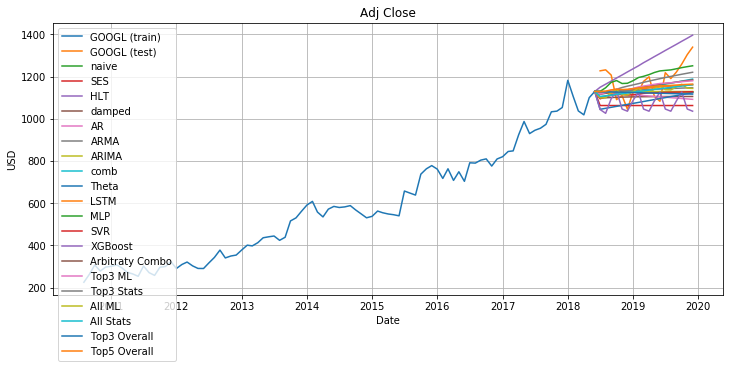

In [52]:
%%time
#attribute = 'Adj Close'
#ticker_sym = 'AAPL'
plt.figure(figsize=(12,5))
plt.plot( data_train[ticker_sym] ,label=ticker_sym+' (train)')
plt.plot( data_test[ticker_sym] ,label=ticker_sym+' (test)')

for method in pred_df_ns.columns:
    plt.plot( pred_df_ns[method] ,label=method)

plt.legend()
plt.title(attribute)
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()

### Define Accuracy Metrics <a class="anchor" id="4.7"></a>

In [32]:
def smape(y, y_hat):
    h = len(y)
    smape = (np.abs(y - y_hat)) / ( (np.abs(y)) + ((np.abs(y_hat)) ))
    smape = 2 * 100 * (np.sum(np.nan_to_num(smape, copy=True, nan=0.0)) / (h))
    return smape

In [33]:
def mase(y, y_hat, y_hist, y_hist_shift):
    h = len(y)
    numerator = np.sum(np.nan_to_num(( np.abs(y - y_hat) ), copy=True, nan=0.0)) / h

    denominator = np.abs(y_hist - y_hist_shift)
    denominator = np.sum(np.nan_to_num(denominator, copy=True, nan=0.0)) / len(denominator)
    
    return numerator  / denominator

In [34]:
def owa(smape_model, smape_rw, mase_model, mase_rw):
    return 0.5 * ((smape_model/smape_rw) + (mase_model/mase_rw))

### Forecast Errors of All Models <a class="anchor" id="4.8"></a>

In [35]:
def get_error_dict(preds_ns, data_train, data_test, ticker_sym, m=12):
    y_hist = data_train[ticker_sym].values # historical values (training data)
    y_hist_shift = data_train[ticker_sym].shift(m).values # historical values shifted

    error_dict_ns = {}

    # testing errors on non-stationary data:

    # first establish errors for random walk for use in OWA calculation
    y_hat = preds_ns['naive']
    y = data_test[ticker_sym].values
    smape_rw = smape(y, y_hat)
    mase_rw = mase(y, y_hat, y_hist, y_hist_shift)

    # now calculate errors for all models tested
    for k in preds_ns.keys():
        y_hat = preds_ns[k]
        #y = data_test_stationary[ticker_sym].values
        smape_model = smape(y, y_hat)
        mase_model = mase(y, y_hat, y_hist, y_hist_shift)
        error_dict_ns[k] = [smape_model, mase_model, owa(smape_model, smape_rw, mase_model, mase_rw)]

    return error_dict_ns

In [36]:
def get_full_error_dicts(preds_ns, data_train, data_test, ticker_sym, m=12, max_nb_forecasts=18, decimals=3):
    y_hist = data_train[ticker_sym].values # historical values (training data)
    y_hist_shift = data_train[ticker_sym].shift(m).values # historical values shifted

    error_dict_smape = {}
    error_dict_mase = {}
    error_dict_owa = {}    

    # for all models tested
    for k in preds_ns.keys():
        
        smape_for_all_horizons = []
        mase_for_all_horizons = []
        owa_for_all_horizons = []
        
        for error_horizon in range(1,max_nb_forecasts+1):

            # first establish error of random walk for use in OWA calculation
            y_hat_rw = preds_ns['naive'][0:error_horizon]
            y = data_test[ticker_sym].values[0:error_horizon]
            smape_rw = smape(y, y_hat_rw)
            mase_rw = mase(y, y_hat_rw, y_hist, y_hist_shift)
        
            y_hat = preds_ns[k][0:error_horizon]
            smape_model = smape(y, y_hat)
            mase_model = mase(y, y_hat, y_hist, y_hist_shift)
            owa_model = owa(smape_model, smape_rw, mase_model, mase_rw)
            
            smape_for_all_horizons.append(smape_model)
            mase_for_all_horizons.append(mase_model)
            owa_for_all_horizons.append(owa_model)

        error_dict_smape[k] = np.array(smape_for_all_horizons).round(decimals)
        error_dict_mase[k] = np.array(mase_for_all_horizons).round(decimals+1)
        error_dict_owa[k] = np.array(owa_for_all_horizons).round(decimals+1)

    return error_dict_smape, error_dict_mase, error_dict_owa

In [58]:
error_dict_smape, error_dict_mase, error_dict_owa = get_full_error_dicts(preds_ns, data_train, data_test, ticker_sym, m=12, max_nb_forecasts=18)

#### sMAPE Summary <a class="anchor" id="4.8.1"></a>

In [59]:
smape_df = pd.DataFrame(error_dict_smape).T
smape_df.columns = list(range(1,smape_df.shape[1]+1))
smape_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
naive,8.320,8.506,7.893,6.790,5.781,6.109,5.278,4.647,4.591,4.731,4.485,4.461,4.701,4.743,4.949,5.318,5.851,6.472
SES,14.365,14.551,13.940,11.101,9.745,8.402,8.026,7.751,8.023,8.425,8.026,7.513,7.984,8.224,8.600,9.118,9.782,10.518
HLT,6.549,6.108,4.872,5.896,6.406,7.941,8.145,8.436,8.305,8.129,8.814,9.657,9.552,9.704,9.738,9.646,9.418,9.126
damped,11.130,11.243,10.569,8.181,6.673,6.464,5.825,5.348,5.459,5.731,5.223,4.958,5.324,5.474,5.772,6.221,6.825,7.508
AR,8.509,8.789,8.271,6.884,5.668,5.827,5.141,4.657,4.786,5.095,4.634,4.410,4.841,5.060,5.430,5.955,6.635,7.397
ARMA,8.191,8.625,7.931,7.050,6.323,6.929,6.370,6.009,5.382,5.015,5.177,5.532,5.251,4.937,4.692,4.641,4.780,5.031
ARIMA,8.319,8.505,7.892,6.789,5.781,6.109,5.278,4.648,4.591,4.731,4.486,4.461,4.701,4.743,4.949,5.318,5.851,6.472
comb,10.632,10.576,9.725,7.940,6.614,6.805,5.939,5.337,5.057,4.975,4.906,5.063,5.025,4.798,4.742,4.858,5.143,5.522
Theta,16.055,16.016,15.183,12.126,10.550,9.156,8.538,8.027,8.071,8.249,7.627,7.090,7.327,7.336,7.484,7.778,8.219,8.736
LSTM,8.496,8.927,8.402,7.082,6.026,6.381,5.612,5.062,4.822,4.793,4.693,4.806,4.864,4.738,4.787,5.011,5.409,5.904


#### MASE Summary <a class="anchor" id="4.8.2"></a>

In [60]:
mase_df = pd.DataFrame(error_dict_mase).T
mase_df.columns = list(range(1,mase_df.shape[1]+1))
mase_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
naive,0.9739,0.9967,0.9224,0.7877,0.6690,0.6970,0.6021,0.5301,0.5239,0.5408,0.5121,0.5078,0.5368,0.5420,0.5668,0.6118,0.6780,0.7564
SES,1.6341,1.6569,1.5826,1.2561,1.0981,0.9445,0.8992,0.8661,0.8958,0.9416,0.8955,0.8375,0.8919,0.9189,0.9625,1.0241,1.1049,1.1962
HLT,0.7731,0.7238,0.5774,0.6873,0.7442,0.9133,0.9399,0.9770,0.9663,0.9503,1.0338,1.1350,1.1283,1.1525,1.1627,1.1574,1.1347,1.1030
damped,1.2855,1.3003,1.2192,0.9421,0.7678,0.7362,0.6625,0.6075,0.6200,0.6516,0.5937,0.5628,0.6058,0.6229,0.6580,0.7121,0.7862,0.8715
AR,0.9951,1.0285,0.9647,0.7983,0.6565,0.6655,0.5867,0.5310,0.5456,0.5812,0.5286,0.5022,0.5523,0.5771,0.6202,0.6825,0.7651,0.8592
ARMA,0.9593,1.0101,0.9266,0.8170,0.7302,0.7899,0.7260,0.6847,0.6134,0.5723,0.5906,0.6301,0.5991,0.5635,0.5360,0.5323,0.5526,0.5875
ARIMA,0.9738,0.9966,0.9223,0.7876,0.6690,0.6970,0.6021,0.5301,0.5239,0.5408,0.5121,0.5079,0.5368,0.5420,0.5668,0.6118,0.6780,0.7564
comb,1.2309,1.2270,1.1264,0.9157,0.7616,0.7743,0.6757,0.6071,0.5756,0.5675,0.5589,0.5754,0.5727,0.5472,0.5422,0.5582,0.5959,0.6463
Theta,1.8120,1.8114,1.7137,1.3642,1.1830,1.0241,0.9532,0.8949,0.9005,0.9222,0.8524,0.7920,0.8212,0.8232,0.8422,0.8793,0.9357,1.0029
LSTM,0.9937,1.0438,0.9794,0.8204,0.6964,0.7275,0.6396,0.5767,0.5498,0.5476,0.5355,0.5468,0.5550,0.5411,0.5482,0.5768,0.6275,0.6914


#### OWA Summary <a class="anchor" id="4.8.3"></a>

In [61]:
owa_df = pd.DataFrame(error_dict_owa).T
owa_df.columns = list(range(1,owa_df.shape[1]+1))
owa_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
naive,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
SES,1.7022,1.6865,1.7409,1.6148,1.6636,1.3653,1.5071,1.6508,1.7289,1.7610,1.7690,1.6666,1.6798,1.7145,1.7181,1.6943,1.6507,1.6033
HLT,0.7905,0.7221,0.6216,0.8704,1.1103,1.3052,1.5521,1.8291,1.8269,1.7377,1.9919,2.1998,2.0668,2.0860,2.0097,1.8528,1.6416,1.4342
damped,1.3288,1.3132,1.3303,1.2004,1.1510,1.0573,1.1020,1.1484,1.1863,1.2082,1.1619,1.1097,1.1305,1.1517,1.1637,1.1669,1.1630,1.1561
AR,1.0222,1.0326,1.0468,1.0137,0.9809,0.9543,0.9742,1.0019,1.0420,1.0758,1.0327,0.9888,1.0293,1.0657,1.0958,1.1177,1.1313,1.1394
ARMA,0.9847,1.0137,1.0046,1.0377,1.0926,1.1338,1.2064,1.2923,1.1716,1.0591,1.1537,1.2404,1.1165,1.0403,0.9469,0.8713,0.8160,0.7771
ARIMA,0.9999,0.9999,0.9999,0.9999,1.0000,1.0000,1.0000,1.0001,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
comb,1.2709,1.2372,1.2266,1.1660,1.1412,1.1125,1.1238,1.1468,1.1002,1.0505,1.0925,1.1340,1.0678,1.0105,0.9575,0.9129,0.8790,0.8538
Theta,1.8950,1.8501,1.8907,1.7589,1.7966,1.4841,1.6004,1.7077,1.7386,1.7244,1.6824,1.5744,1.5442,1.5328,1.4991,1.4499,1.3924,1.3379
LSTM,1.0207,1.0483,1.0631,1.0423,1.0417,1.0442,1.0628,1.0885,1.0499,1.0128,1.0460,1.0770,1.0343,0.9986,0.9673,0.9425,0.9250,0.9132


# Test for Multiple Series <a class="anchor" id="5"></a>

### Select Series/Tickers (Exclude Those Used for Gridsearch Hyperparameter Optimisation)

In [37]:
import random

In [38]:
nb_samples = int(0.2 * data.shape[1]) # nb_samples = 20% of cols in full data set
#nb_samples = 10
nb_samples

80

In [39]:
## randomly sample nb_samples from original set of tickers (these were used in Gridsearch Hyperparameter Optimisation)
random.seed(42)
sub_set_cols = random.sample(list(data.columns), nb_samples)

In [40]:
## remove all tickers that were used in Gridsearch Hyperparameter Optimisation
test_icker_list = list(data.columns)
for t in sub_set_cols:
    test_icker_list.remove(t)

In [41]:
len(test_icker_list)

323

### Select Series (Tickers) for Test <a class="anchor" id="5.1"></a>

In [42]:
## This part must be removed or changed when all tickers must be used for full final test
#select random subset of tickers from entire list with random seed for repeatibility
#import random
#random.seed(7)
#test_icker_list = random.sample(list(data.columns), 25)

### Fit All ML and Stats Models, Produce Forecasts, and Calculate Errors <a class="anchor" id="5.2"></a>

In [43]:
%%time
for T, ticker_sym in enumerate(test_icker_list):
    print('===================')
    print(T+1,'/',len(test_icker_list),':\t',ticker_sym)
    print('===================')
    
    ###------------------------------------
    ### STATS MODELS:
    ###------------------------------------    
    pred_rand_ns = rand_train_and_pred(data_train, ticker_sym, rand_seed=111, nb_pred=18)
    pred_naive_ns = naive_train_and_pred(data_train, ticker_sym, nb_pred=18)
    pred_SES_ns = SES_train_and_pred(data_train, ticker_sym, alpha=0.2, nb_pred=18, repl_nan=0.0)
    pred_HLT_ns = HLT_train_and_pred(data_train, ticker_sym, alpha=0.2, beta=0.2, nb_pred=18)
    pred_damped_ns = damped_train_and_pred(data_train, ticker_sym, alpha=0.2, beta=0.8, phi=0.8, nb_pred=18)
    pred_ar = AR_train_and_pred(data_train, ticker_sym, order=(1,0,0), nb_pred=18)
    pred_arma = ARMA_train_and_pred(data_train, ticker_sym, order=(5,0,1), nb_pred=18)
    pred_arima = ARIMA_train_and_pred(data_train, ticker_sym, order=(1,1,1), nb_pred=18)
    pred_comb_ns = comb_train_and_pred(pred_SES_ns, pred_HLT_ns, pred_damped_ns)
    pred_theta = theta_train_and_pred(data_train, data_test, ticker_sym, SES_alpha=0.2, repl_nan=0.0, nb_pred=18)
    
    ###------------------------------------
    ### ML MODELS:
    ###------------------------------------    
    # for 10 lagged values
    X_train_10, y_train_10, sc_10 = prepare_data_for_ML_models(data_train, ticker_sym, inp_param=10)
    # for 5 lagged values
    X_train_5, y_train_5, sc_5 = prepare_data_for_ML_models(data_train, ticker_sym, inp_param=5) 
    
    pred_lstm = LSTM_train_and_pred(X_train_10, y_train_10, sc_10, nb_preds=18, hidden_units=21, inp_param=10, learning_rate=0.001, loss='mean_squared_error', epochs=500, batch_size=10, verbose=0)
    pred_mlp = MLP_train_and_pred(X_train_10, y_train_10, sc_10, nb_preds=18, hidden_units=21, inp_param=10, learning_rate=0.001, loss='mean_squared_error', epochs=500, batch_size=10, verbose=0)
    pred_svr = SVR_train_and_pred(X_train_10, y_train_10, sc_10, inp_param=10, kernel='rbf', gamma='auto', C=1.0, epsilon=0.05, nb_preds=18)
    pred_xgb = XGBoost_train_and_pred(X_train_5, y_train_5, sc_5, inp_param=5, nb_preds=18, max_depth=3, eval_metric='rmse', n_estimators=100)
    
    ###------------------------------------
    ### COMBO MODELS:
    ###------------------------------------  
    combo_1_pred_list = [pred_HLT_ns, pred_mlp, pred_arima, pred_lstm, pred_damped_ns, pred_SES_ns]
    combo_1_pred = general_combo_train_and_pred(combo_1_pred_list)

    combo_top3_ml_list = [pred_mlp, pred_svr, pred_lstm]
    combo_top3_ml_pred = general_combo_train_and_pred(combo_top3_ml_list)

    combo_top3_stats_list = [pred_arima, pred_ar, pred_arma]
    combo_top3_stats_pred = general_combo_train_and_pred(combo_top3_stats_list)

    combo_all_ml_list = [pred_mlp, pred_svr, pred_lstm, pred_xgb]
    combo_all_ml_pred = general_combo_train_and_pred(combo_all_ml_list)

    combo_all_stats_list = [pred_arima, pred_ar, pred_arma, pred_damped_ns, pred_HLT_ns, pred_SES_ns, pred_theta]
    combo_all_stats_pred = general_combo_train_and_pred(combo_all_stats_list)

    combo_top3_overall_list = [pred_naive_ns, pred_arima, pred_ar]
    combo_top3_overall_pred = general_combo_train_and_pred(combo_top3_overall_list)

    combo_top5_overall_list = [pred_naive_ns, pred_arima, pred_ar,
                               pred_mlp, pred_arma]
    combo_top5_overall_pred = general_combo_train_and_pred(combo_top5_overall_list)
    
    ###------------------------------------
    ### ALL PREDICTIONS:
    ###------------------------------------
    preds_ns = {#'random': pred_rand_ns,
        'naive': pred_naive_ns,
        #'naive2': pred_naive2_ns,
        'SES': pred_SES_ns,
        'HLT': pred_HLT_ns,
        'damped': pred_damped_ns,
        'AR': pred_ar,
        'ARMA': pred_arma,
        'ARIMA': pred_arima,
        'comb': pred_comb_ns,
        'Theta': pred_theta,
        'LSTM':pred_lstm,
        'MLP': pred_mlp,
        'SVR': pred_svr,
        'XGBoost': pred_xgb,
        'Arbitraty Combo': combo_1_pred,
        'Top3 ML':combo_top3_ml_pred,
        'Top3 Stats':combo_top3_stats_pred,
        'All ML':combo_all_ml_pred,
        'All Stats':combo_all_stats_pred,
        'Top3 Overall':combo_top3_overall_pred,
        'Top5 Overall':combo_top5_overall_pred}
    
    ###------------------------------------
    ### ERRORS:
    ###------------------------------------
    # get error metrics for specific ticker
    error_dict_smape, error_dict_mase, error_dict_owa = get_full_error_dicts(preds_ns, data_train, data_test, ticker_sym, m=12, max_nb_forecasts=18)

    # add to cumulative error metrics (for all tickers so far)
    if T == 0:
        cumlative_error_dict_smape = error_dict_smape.copy() # initiate cumulative error dict
        cumlative_error_dict_mase = error_dict_mase.copy()
        cumlative_error_dict_owa = error_dict_owa.copy()

    else:
        for k in cumlative_error_dict_smape.keys():
            cumlative_error_dict_smape[k] += error_dict_smape[k]
            cumlative_error_dict_mase[k] += error_dict_mase[k]
            cumlative_error_dict_owa[k] += error_dict_owa[k]

    # average error metrics for all tickers
    avg_error_smape = cumlative_error_dict_smape.copy()
    avg_error_mase = cumlative_error_dict_mase.copy()
    avg_error_owa = cumlative_error_dict_owa.copy()

    for k in avg_error_smape.keys():
        avg_error_smape[k] = avg_error_smape[k] / len(test_icker_list)
        avg_error_mase[k] = avg_error_mase[k] / len(test_icker_list)
        avg_error_owa[k] = avg_error_owa[k] / len(test_icker_list)

1 / 323 :	 AAL
building LSTM model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
training LSTM model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
2 / 323 :	 AAPL


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
3 / 323 :	 AAP


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
4 / 323 :	 ABC


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
5 / 323 :	 ABMD


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
6 / 323 :	 ABT


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
7 / 323 :	 ACN
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
8 / 323 :	 ADBE


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
9 / 323 :	 ADI
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
10 / 323 :	 ADM
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
11 / 323 :	 

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
16 / 323 :	 AGN


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
17 / 323 :	 AIG
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
18 / 323 :	 ALGN


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
19 / 323 :	 ALL


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
20 / 323 :	 ALXN


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
21 / 323 :	 AMAT
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
22 / 323 :	 AMD
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
23 / 323 :

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
24 / 323 :	 AMP


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
25 / 323 :	 AMTD
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
26 / 323 :	 AMT
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
27 / 323 :

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
31 / 323 :	 APH
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
32 / 323 :	 ATVI


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
33 / 323 :	 AVGO
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
34 / 323 :	 AWK


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
35 / 323 :	 AXP


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
36 / 323 :	 A


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
37 / 323 :	 BAC
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
38 / 323 :	 BA


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
39 / 323 :	 BBY
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
40 / 323 :	 BIIB


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
41 / 323 :	 BKNG
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
42 / 323 :	 BKR
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
43 / 323 :

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
46 / 323 :	 BMY
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
47 / 323 :	 BSX
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
48 / 323 :	

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
49 / 323 :	 CAH
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
50 / 323 :	 CAT


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
51 / 323 :	 CB


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
52 / 323 :	 CCI


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
53 / 323 :	 CCL
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
54 / 323 :	 CDNS


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
55 / 323 :	 CERN
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
56 / 323 :	 CHD
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
57 / 323 :

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
58 / 323 :	 CHRW
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
59 / 323 :	 CHTR
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
60 / 323 

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
62 / 323 :	 CLF
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
63 / 323 :	 CLX


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
64 / 323 :	 CMA


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
65 / 323 :	 CME


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
66 / 323 :	 CMG


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
67 / 323 :	 CMI
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
68 / 323 :	 CMS


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
69 / 323 :	 CNC


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
70 / 323 :	 CNP
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
71 / 323 :	 COF


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
72 / 323 :	 COG


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
73 / 323 :	 COP
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
74 / 323 :	 COST
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
75 / 323 :

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
76 / 323 :	 CPRT


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
77 / 323 :	 CRM
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
78 / 323 :	 CSCO
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
79 / 323 :

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
82 / 323 :	 CTXS
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
83 / 323 :	 CVS
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
84 / 323 :

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
88 / 323 :	 DG


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
89 / 323 :	 DHR
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
90 / 323 :	 DIS


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
91 / 323 :	 DKS
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
92 / 323 :	 DLTR


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
93 / 323 :	 DPZ
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
94 / 323 :	 DRI
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
95 / 323 :	

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
97 / 323 :	 DVN
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
98 / 323 :	 DXCM
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
99 / 323 :

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
102 / 323 :	 EBAY
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
103 / 323 :	 ECL
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
104 / 32

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
110 / 323 :	 ETN
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
111 / 323 :	 ETR
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
112 / 323

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
114 / 323 :	 EXAS
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
115 / 323 :	 EXPE
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
116 / 3

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
118 / 323 :	 FE


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
119 / 323 :	 FISV
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
120 / 323 :	 FIS
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
121 / 32

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
126 / 323 :	 F
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
127 / 323 :	 GD
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
128 / 323 :	

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
130 / 323 :	 GIS
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
131 / 323 :	 GLW
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
132 / 323

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
133 / 323 :	 GOOGL


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
134 / 323 :	 GPN
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
135 / 323 :	 GPS
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
136 / 323

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
141 / 323 :	 HES
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
142 / 323 :	 HIG
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
143 / 323

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
144 / 323 :	 HRL
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
145 / 323 :	 HUM
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
146 / 323

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
148 / 323 :	 ILMN
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
149 / 323 :	 INCY


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
150 / 323 :	 IP
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
151 / 323 :	 ISRG
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
152 / 323

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
158 / 323 :	 JNPR
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
159 / 323 :	 JPM


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
160 / 323 :	 JWN
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
161 / 323 :	 KEY
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
162 / 323

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
164 / 323 :	 KMB
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
165 / 323 :	 KMI


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
166 / 323 :	 KMX
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
167 / 323 :	 KO
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
168 / 323 

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
174 / 323 :	 LIN


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
175 / 323 :	 LLY


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
176 / 323 :	 LMT


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
177 / 323 :	 LNG
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
178 / 323 :	 LOW
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
179 / 323

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
185 / 323 :	 MCD
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
186 / 323 :	 MCK


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
187 / 323 :	 MCO
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
188 / 323 :	 MDLZ
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
189 / 32

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
191 / 323 :	 MET
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
192 / 323 :	 MGM
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
193 / 323

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
194 / 323 :	 MKC


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
195 / 323 :	 MKTX
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
196 / 323 :	 MLM
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
197 / 32

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
198 / 323 :	 MMM


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
199 / 323 :	 MNST
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
200 / 323 :	 MOS
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
201 / 32

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
205 / 323 :	 MRVL
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
206 / 323 :	 MSCI
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
207 / 3

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
216 / 323 :	 NEM
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
217 / 323 :	 NFLX


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
218 / 323 :	 NI
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
219 / 323 :	 NKE


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
220 / 323 :	 NLY
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
221 / 323 :	 NOC
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
222 / 323

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
226 / 323 :	 NUE
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
227 / 323 :	 NXPI
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
228 / 32

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
230 / 323 :	 ON
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
231 / 323 :	 ORCL
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
232 / 323

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
235 / 323 :	 PCAR
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
236 / 323 :	 PCG


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
237 / 323 :	 PEAK
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
238 / 323 :	 PEG
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
239 / 32

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
244 / 323 :	 PLD
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
245 / 323 :	 PODD


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
246 / 323 :	 PPG


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
247 / 323 :	 PPL
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
248 / 323 :	 PRU


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
249 / 323 :	 PSA


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
250 / 323 :	 QCOM
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
251 / 323 :	 RCL


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
252 / 323 :	 REGN
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
253 / 323 :	 RF
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
254 / 323

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
256 / 323 :	 ROP


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
257 / 323 :	 ROST
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
258 / 323 :	 RTN
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
259 / 32

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
262 / 323 :	 SHW


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
263 / 323 :	 SLB
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
264 / 323 :	 SO
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
265 / 323 

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
266 / 323 :	 SPG


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
267 / 323 :	 SRE


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
268 / 323 :	 SSNC


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
269 / 323 :	 STT
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
270 / 323 :	 STX
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
271 / 323

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
273 / 323 :	 SYK


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
274 / 323 :	 SYY
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
275 / 323 :	 S
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
276 / 323 :

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
284 / 323 :	 TRV


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
285 / 323 :	 TSCO


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
286 / 323 :	 TSLA
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
287 / 323 :	 TSN
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
288 / 32

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
290 / 323 :	 ULTA
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
291 / 323 :	 UNH


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
292 / 323 :	 UNP


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
293 / 323 :	 UPS


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
294 / 323 :	 USB
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
295 / 323 :	 VFC
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
296 / 323

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
298 / 323 :	 VMW


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
299 / 323 :	 VRSK


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
300 / 323 :	 VTR
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
301 / 323 :	 VZ
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
302 / 323 

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
303 / 323 :	 WAT


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
304 / 323 :	 WDC


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
305 / 323 :	 WEC
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
306 / 323 :	 WELL


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
307 / 323 :	 WFC
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
308 / 323 :	 WHR
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
309 / 323

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
311 / 323 :	 WMT
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
312 / 323 :	 WU
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
313 / 323 

C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
318 / 323 :	 X


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
319 / 323 :	 YNDX
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
320 / 323 :	 YUM


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
321 / 323 :	 ZBH


C:\Users\Ruan Pretorius\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
322 / 323 :	 ZBRA
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
323 / 323 :	 ZION
building LSTM model...
training LSTM model...
making LSTM predictions...
done.
building MLP model...
training MLP model...
making MLP predictions...
done.
building SVR model...
training SVR model...
making SVR predictions...
done.
building XGBoost model...
training XGBoost model...
making XGBoost predictions...
done.
Wall ti

### Forecast Errors of All Models <a class="anchor" id="5.3"></a>

#### sMAPE Summary (Averaged Across All Series/Tickers) <a class="anchor" id="5.3.1"></a>

In [44]:
avg_error_smape_df = pd.DataFrame(avg_error_smape).T
avg_error_smape_df.columns = list(range(1,avg_error_smape_df.shape[1]+1))
avg_error_smape_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
naive,5.138545,7.058260,8.033659,8.619396,9.366545,10.384390,10.758824,11.237669,11.780520,12.314108,12.975291,13.587799,14.210433,14.981508,15.633300,16.197873,16.768669,17.300046
SES,8.615300,10.594616,11.469904,11.754579,12.220226,12.892666,13.170712,13.587799,14.089511,14.621950,15.223375,15.803192,16.365916,17.074443,17.675161,18.205260,18.748489,19.279551
HLT,7.536263,9.062963,9.912963,11.263319,12.310235,14.008715,14.715180,15.293610,15.964406,16.517307,17.378226,18.057548,18.700087,19.528576,20.224851,20.828786,21.375059,21.876279
damped,6.612768,8.403743,9.278495,9.920325,10.794050,11.820347,12.221805,12.713659,13.246223,13.807746,14.459873,15.091046,15.720721,16.491276,17.143570,17.722471,18.303563,18.839152
AR,5.684028,7.795563,8.893334,9.416681,10.214889,11.080675,11.546353,12.153885,12.804570,13.523901,14.228573,14.990402,15.760046,16.599805,17.377269,18.097728,18.847381,19.570514
ARMA,6.166644,8.101923,9.165319,9.780591,10.728539,11.588028,12.183291,12.909957,13.620839,14.460437,15.193034,16.036260,16.891387,17.783505,18.640152,19.455830,20.297511,21.135121
ARIMA,5.518740,7.298254,8.178226,8.849724,9.674740,10.780607,11.185291,11.663693,12.167065,12.650483,13.285811,13.849885,14.417257,15.139282,15.747786,16.267192,16.797198,17.279752
comb,6.632102,8.482625,9.319065,9.985780,10.733833,11.841957,12.213542,12.648601,13.156074,13.625192,14.280489,14.848870,15.411492,16.141483,16.750331,17.273873,17.770765,18.230492
Theta,11.972573,13.444319,14.073115,14.177567,14.398000,15.051440,15.218362,15.534139,15.959715,16.361071,16.873170,17.332567,17.768313,18.383796,18.853334,19.272282,19.691805,20.105031
LSTM,6.742851,8.601282,9.945861,11.243675,12.570560,14.160059,15.077251,15.895006,16.703926,17.441099,18.341675,19.069548,19.735851,20.531111,21.241458,21.800666,22.311056,22.797542


#### MASE Summary (Averaged Across All Series/Tickers) <a class="anchor" id="5.3.2"></a>

In [45]:
avg_error_mase_df = pd.DataFrame(avg_error_mase).T
avg_error_mase_df.columns = list(range(1,avg_error_mase_df.shape[1]+1))
avg_error_mase_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
naive,0.470347,0.629041,0.725144,0.761848,0.822868,0.882193,0.913308,0.963869,1.024780,1.089068,1.144829,1.212964,1.283223,1.360961,1.430415,1.491360,1.559055,1.627981
SES,0.761644,0.936494,1.025111,1.034667,1.073597,1.102133,1.127670,1.175117,1.234064,1.300068,1.352429,1.419469,1.485839,1.559278,1.625584,1.685500,1.752500,1.822437
HLT,0.621126,0.744125,0.826693,0.947431,1.044601,1.183717,1.246446,1.299742,1.364917,1.419688,1.492721,1.558288,1.622332,1.701407,1.770776,1.832067,1.889801,1.947301
damped,0.581260,0.731347,0.820626,0.866623,0.940593,1.005933,1.040785,1.093626,1.154475,1.220806,1.276232,1.345023,1.415554,1.493049,1.562706,1.624229,1.691289,1.759515
AR,0.508182,0.684471,0.792167,0.825640,0.892339,0.937803,0.978268,1.041634,1.112487,1.193263,1.252935,1.334834,1.418875,1.503107,1.584079,1.658997,1.742491,1.828318
ARMA,0.546385,0.711030,0.815659,0.858121,0.939220,0.987154,1.036950,1.107641,1.181211,1.269336,1.331902,1.418303,1.507309,1.595132,1.681496,1.762793,1.851801,1.944463
ARIMA,0.503129,0.648611,0.737076,0.784702,0.854911,0.925085,0.960841,1.012170,1.070133,1.128822,1.182189,1.244979,1.308887,1.381644,1.446782,1.503039,1.565695,1.628917
comb,0.574091,0.732110,0.816939,0.866533,0.930229,1.003176,1.034783,1.080115,1.136872,1.193528,1.248964,1.311032,1.373915,1.447214,1.511590,1.566634,1.623971,1.682660
Theta,0.969716,1.112940,1.185753,1.178827,1.197321,1.224191,1.240735,1.279593,1.329645,1.381780,1.425964,1.480732,1.533935,1.598026,1.651451,1.699795,1.753997,1.810411
LSTM,0.596720,0.756846,0.898784,1.051789,1.190360,1.331879,1.433019,1.533538,1.636433,1.742274,1.845552,1.942169,2.033428,2.131095,2.224655,2.302636,2.380346,2.460148


#### OWA Summary (Averaged Across All Series/Tickers) <a class="anchor" id="5.3.3"></a>

In [46]:
avg_error_owa_df = pd.DataFrame(avg_error_owa).T
avg_error_owa_df.columns = list(range(1,avg_error_owa_df.shape[1]+1))
avg_error_owa_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
naive,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
SES,5.345500,2.041166,1.632503,1.487290,1.414226,1.342668,1.324551,1.294115,1.263291,1.244254,1.228721,1.217315,1.203149,1.186411,1.175320,1.168183,1.157137,1.149719
HLT,5.595689,2.178326,1.589858,1.513002,1.511643,1.496536,1.519619,1.514867,1.513554,1.509280,1.518259,1.522664,1.519875,1.517250,1.521836,1.528600,1.518609,1.508827
damped,4.336561,1.690537,1.369925,1.289340,1.270974,1.233738,1.218882,1.204220,1.183778,1.178905,1.171418,1.167425,1.160673,1.152768,1.147242,1.143872,1.139988,1.136978
AR,2.224334,1.208894,1.150667,1.133536,1.125384,1.100348,1.107454,1.115263,1.114575,1.126181,1.123978,1.134465,1.142229,1.141105,1.148378,1.157598,1.165194,1.173516
ARMA,2.841309,1.366521,1.223204,1.197150,1.199776,1.160557,1.176245,1.192183,1.195576,1.214307,1.215127,1.233607,1.248590,1.248705,1.264042,1.280978,1.292665,1.306034
ARIMA,1.743318,1.143346,1.040087,1.047347,1.049865,1.052626,1.052988,1.052670,1.045638,1.039432,1.038043,1.033905,1.030350,1.026702,1.024770,1.023007,1.020890,1.018147
comb,4.341350,1.699052,1.340849,1.256793,1.227736,1.197820,1.188777,1.178736,1.164063,1.154854,1.149176,1.143228,1.135870,1.129341,1.127507,1.124566,1.115611,1.108472
Theta,7.157767,2.722813,2.052318,1.813283,1.703603,1.587033,1.551281,1.490689,1.445879,1.409072,1.382015,1.362401,1.337065,1.317153,1.299432,1.289115,1.272114,1.260431
LSTM,2.547755,1.735323,1.390329,1.471784,1.514086,1.543109,1.594635,1.610906,1.608467,1.612995,1.635194,1.640623,1.627551,1.609465,1.600384,1.596741,1.578713,1.562089


#### Save Error Results to .csv Files

In [47]:
avg_error_smape_df.to_csv('../data/avg_err/avg_sMAPE_323_series_optimised_models_final.csv')
print('average sMAPE saved.')

avg_error_mase_df.to_csv('../data/avg_err/avg_MASE_323_series_optimised_models_final.csv')
print('average MASE saved.')

avg_error_owa_df.to_csv('../data/avg_err/avg_OWA_323_series_optimised_models_final.csv')
print('average OWA saved.')

average sMAPE saved.
average MASE saved.
average OWA saved.


## Error Plot for All Models and Specific Forecast Horizon <a class="anchor" id="5.4"></a>

#### sMAPE Plot <a class="anchor" id="5.4.1"></a>

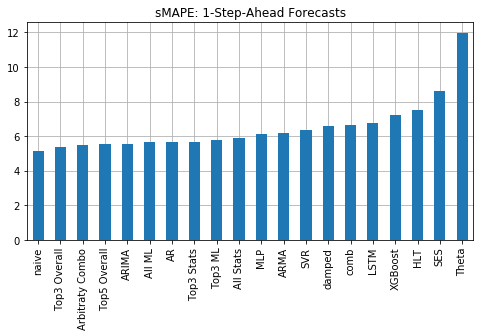

In [56]:
plot_fc_horizon = 1

#plt.figure(figsize=(8,4))
ax = avg_error_smape_df.sort_values(by=[plot_fc_horizon])[plot_fc_horizon].plot(kind='bar', figsize=(8,4), grid=True)
ax.set_axisbelow(True)
plt.title('sMAPE: {:d}-Step-Ahead Forecasts'.format(plot_fc_horizon))
plt.xticks(rotation=90); #, ha="right"

plt.savefig('../data/plots/sMAPE_optimised_{:d}_step.png'.format(plot_fc_horizon), bbox_inches='tight', dpi=200)

#### MASE Plot <a class="anchor" id="5.4.2"></a>

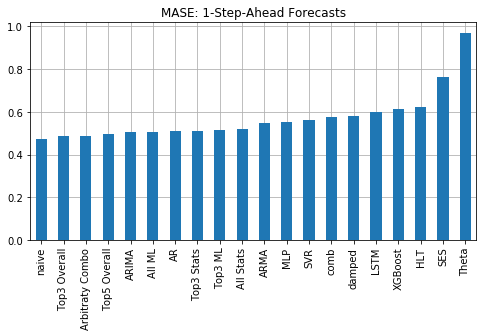

In [57]:
plot_fc_horizon = 1

#plt.figure(figsize=(8,4))
ax = avg_error_mase_df.sort_values(by=[plot_fc_horizon])[plot_fc_horizon].plot(kind='bar', figsize=(8,4), grid=True)
ax.set_axisbelow(True)
plt.title('MASE: {:d}-Step-Ahead Forecasts'.format(plot_fc_horizon))
plt.xticks(rotation=90); #, ha="right"

plt.savefig('../data/plots/MASE_optimised_{:d}_step.png'.format(plot_fc_horizon), bbox_inches='tight', dpi=200)

#### OWA Plot <a class="anchor" id="5.4.3"></a>

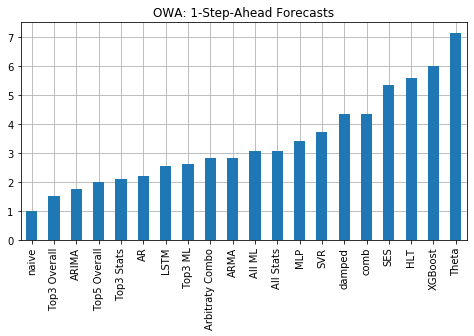

In [58]:
plot_fc_horizon = 1

#plt.figure(figsize=(8,4))
ax = avg_error_owa_df.sort_values(by=[plot_fc_horizon])[plot_fc_horizon].plot(kind='bar', figsize=(8,4), grid=True)
ax.set_axisbelow(True)
plt.title('OWA: {:d}-Step-Ahead Forecasts'.format(plot_fc_horizon))
plt.xticks(rotation=90); #, ha="right"

plt.savefig('../data/plots/OWA_optimised_{:d}_step.png'.format(plot_fc_horizon), bbox_inches='tight', dpi=200)